In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [3]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas/EDA"

In [4]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [5]:
adata_2 = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad")

In [6]:
adata.obsm["X_multi_vi"] = adata_2.obsm["X_multi_vi"]

In [7]:
new_annotation = pd.read_csv("/lustre/groups/ml01/workspace/moscot_paper/pancreas/EDA/endocrine_refinement.csv")

In [8]:
adata.obs["Fev_delta_refinement"] = new_annotation["Fev_delta_refinement"].values
adata.obs["Ngn3_high_refinement"] = new_annotation["Ngn3_high_refinement"].values
adata.obs["refinement"] = new_annotation["refinement"].values

In [9]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [10]:
adata = adata[adata.obs["celltype"].isin(endocrine_celltypes)].copy()

In [11]:
sc.tl.umap(adata)

In [12]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [13]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#17becf', 'Fev+ Delta,1':'#98df8a',
      'Ngn3 high cycling': '#adf542',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [14]:
adata.obs["refinement"] = adata.obs["refinement"].astype("category")
adata.uns["refinement_colors"] = [color_dict[ct] for ct in adata.obs["refinement"].cat.categories]

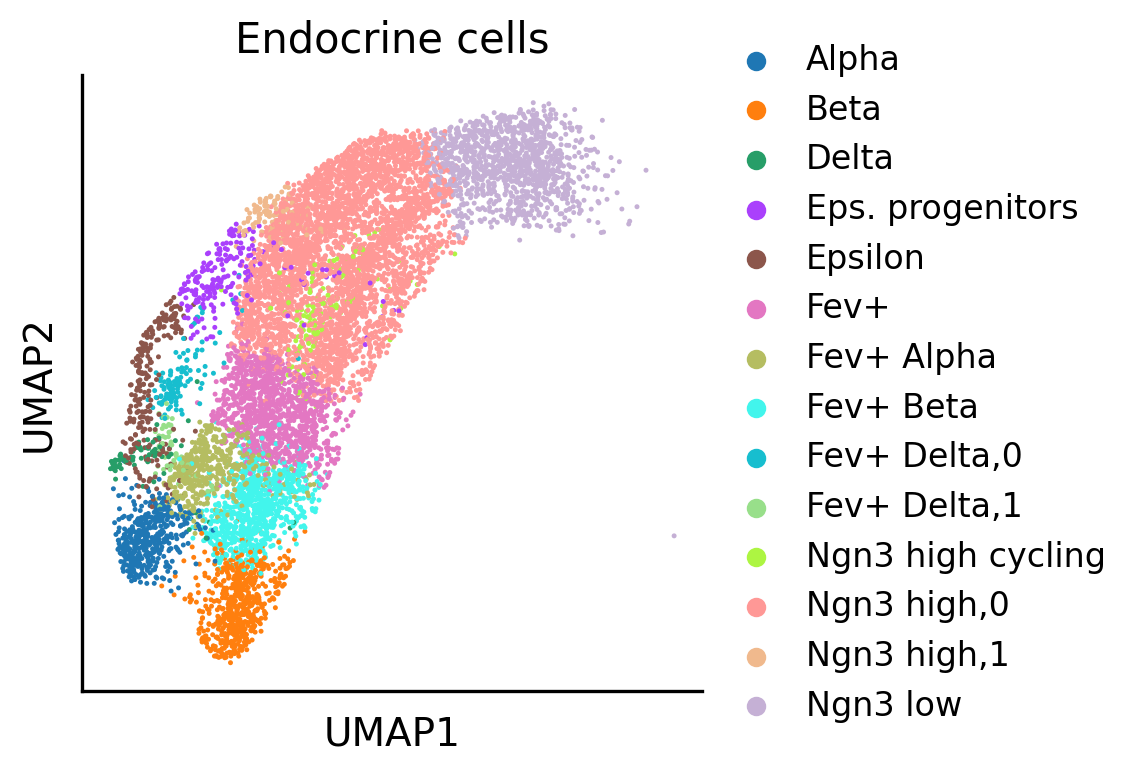

In [15]:
fig = sc.pl.umap(adata, color="refinement", show=True, return_fig=True, title="Endocrine cells")
fig

# Compute cost matrix and train the model

In [16]:
import pygsp

In [17]:
sc.pp.neighbors(adata, use_rep="X_multi_vi", key_added="multi_vi", n_neighbors=30)

In [18]:
cell_ids_source = adata[adata.obs["time"]==14.5].obs_names
cell_ids_target = adata[adata.obs["time"]==15.5].obs_names

In [19]:
assert (adata.obs.iloc[:(len(cell_ids_source))].index == cell_ids_source).all()
assert (adata.obs.iloc[(len(cell_ids_source)):].index == cell_ids_target).all()

In [20]:
G = pygsp.graphs.Graph(adata.obsp["multi_vi_connectivities"])

In [21]:
G.estimate_lmax()

In [22]:
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(adata)))
custom_cost = pd.DataFrame(data=-np.log(diffusion_distances[:len(cell_ids_source), len(cell_ids_source):].copy())+1e-15, index=cell_ids_source, columns=cell_ids_target)

In [23]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

In [24]:
tp0[14.5, 15.5].set_xy(custom_cost, tag="cost_matrix")

In [25]:
tp0 = tp0.solve(max_iterations=1e8)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5539, 3826)].            


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

In [26]:
tp0.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/", overwrite=True)

INFO     Successfully saved the problem as                                                   
         `/lustre/groups/ml01/workspace/moscot_paper/pancreas/TemporalProblem.pkl`           
